<a href="https://colab.research.google.com/github/SDS-AAU/UNISTRA-DS-2022/blob/master/notebooks/M3_workshop_sbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!pip install -qU transformers sentence-transformers

# Introduction & Applications: Semantic Similarity 

xxx

## Toy example

A simple example of a couple of sentences. Imagine our task is to calculate semantic similarity between them:

In [84]:
sentences = ["purple is the best city in the forest",
             "there is an art to getting your way and throwing bananas on to the street is not it",
             "it is not often you find soggy bananas on the street",
             "green should have smelled more tranquil but somehow it just tasted rotten",
             "joyce enjoyed eating pancakes with ketchup",
             "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled",
             "to get your way you must not bombard the road with yellow fruit" ]

### BERT

Lets we'll take a look at how we can use transformer models (like BERT) to create sentence vectors for calculating similarity. Let's start by defining a few example sentences.

In [85]:
from transformers import AutoTokenizer, AutoModel
import torch

Initialize our HF transformer model and tokenizer - using a pretrained BERT model.

In [86]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

Tokenize all of our sentences.

In [87]:
tokens = tokenizer(sentences,
                   max_length=128,
                   truncation=True,
                   padding='max_length',
                   return_tensors='pt')

In [88]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [89]:
tokens['input_ids'][0]

tensor([ 101, 6379, 2003, 1996, 2190, 2103, 1999, 1996, 3224,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Process our tokenized tensors through the model.

In [90]:
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

Here we can see the final embedding layer, *last_hidden_state*.

In [91]:
embeddings = outputs.last_hidden_state
embeddings[0]

tensor([[-0.6239, -0.2058,  0.0411,  ...,  0.1490,  0.5681,  0.2381],
        [-0.3694, -0.1485,  0.3780,  ...,  0.4204,  0.5553,  0.1441],
        [-0.7221, -0.3813,  0.2031,  ...,  0.0761,  0.5162,  0.2813],
        ...,
        [-0.1894, -0.3711,  0.3034,  ...,  0.1536,  0.3265,  0.1376],
        [-0.2496, -0.5227,  0.2341,  ...,  0.3419,  0.3164,  0.0256],
        [-0.3311, -0.4430,  0.3492,  ...,  0.3655,  0.2910,  0.0728]],
       grad_fn=<SelectBackward0>)

In [92]:
embeddings[0].shape

torch.Size([128, 768])

Here we have our vectors of length *768*, but we see that these are not *sentence vectors* because we have a vector representation for each token in our sequence (128 in total). We need to perform a mean pooling operation to create the sentence vector.

The first thing we do is multiply each value in our `embeddings` tensor by its respective `attention_mask` value. The `attention_mask` contains **1s** where we have 'real tokens' (eg not padding tokens), and 0s elsewhere - so this operation allows us to ignore non-real tokens.

In [93]:
mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([7, 128, 768])

In [94]:
mask[0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Now we have a masking array that has an equal shape to our output `embeddings` - we multiply those together to apply the masking operation on our outputs.

In [95]:
masked_embeddings = embeddings * mask
masked_embeddings[0]

tensor([[-0.6239, -0.2058,  0.0411,  ...,  0.1490,  0.5681,  0.2381],
        [-0.3694, -0.1485,  0.3780,  ...,  0.4204,  0.5553,  0.1441],
        [-0.7221, -0.3813,  0.2031,  ...,  0.0761,  0.5162,  0.2813],
        ...,
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SelectBackward0>)

Sum the remaining embeddings along axis 1 to get a total value in each of our 768 values.

In [96]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([7, 768])

Next, we count the number of values that should be given attention in each position of the tensor (+1 for real tokens, +0 for non-real).

In [97]:
counted = torch.clamp(mask.sum(1), min=1e-9)
counted.shape

torch.Size([7, 768])

Finally, we get our mean-pooled values as the `summed` embeddings divided by the number of values that should be given attention, `counted`.

In [98]:
mean_pooled = summed / counted
mean_pooled.shape

torch.Size([7, 768])

Now we have our sentence vectors, we can calculate the cosine similarity between each.

In [99]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [100]:
# convert to numpy array from torch tensor
mean_pooled = mean_pooled.detach().numpy()

# calculate similarities (will store in array)
scores = np.zeros((mean_pooled.shape[0], mean_pooled.shape[0]))
for i in range(mean_pooled.shape[0]):
    scores[i, :] = cosine_similarity(
        [mean_pooled[i]],
        mean_pooled
    )[0]

In [101]:
scores

array([[ 1.00000024,  0.18692759,  0.28297698,  0.2962825 ,  0.27451017,
         0.10176268,  0.21696277],
       [ 0.18692759,  1.00000012,  0.72058779,  0.51428938,  0.11749661,
         0.19306946,  0.66182339],
       [ 0.28297698,  0.72058779,  0.99999988,  0.4886443 ,  0.23568955,
         0.17157146,  0.55993086],
       [ 0.2962825 ,  0.51428938,  0.4886443 ,  0.99999988,  0.26985505,
         0.37889439,  0.52388823],
       [ 0.27451015,  0.11749662,  0.23568954,  0.26985505,  1.        ,
         0.23422135, -0.01599767],
       [ 0.10176268,  0.19306944,  0.17157145,  0.37889433,  0.23422135,
         1.        ,  0.22319689],
       [ 0.21696278,  0.66182339,  0.5599308 ,  0.52388823, -0.01599767,
         0.22319692,  1.        ]])

We can visualize these scores:

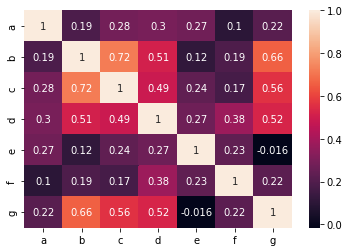

In [108]:
sns.heatmap(scores, xticklabels=labels, yticklabels=labels, annot=True)

### Using sentence-transformers

The `sentence-transformers` library allows us to compress all of the above into just a few lines of code.

In [104]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

We encode the sentences (producing our mean-pooled sentence embeddings) like so:

In [109]:
sentence_embeddings = model.encode(sentences)

And calculate the cosine similarity just like before.

In [110]:
# calculate similarities (will store in array)
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
for i in range(sentence_embeddings.shape[0]):
    scores[i, :] = cosine_similarity(
        [sentence_embeddings[i]],
        sentence_embeddings
    )[0]

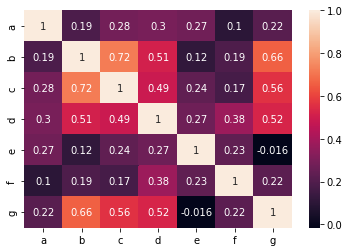

In [112]:
sns.heatmap(scores, xticklabels=labels, yticklabels=labels, annot=True)

We can also writ a small function to find the most similar sentences to each others

In [113]:
#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(scores)-1):
    for j in range(i+1, len(scores)):
        pairs.append({'index': [i, j], 'score': scores[i][j]})

In [114]:
#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

In [115]:
for pair in pairs[0:10]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], pair['score']))

there is an art to getting your way and throwing bananas on to the street is not it 		 it is not often you find soggy bananas on the street 		 Score: 0.7206
there is an art to getting your way and throwing bananas on to the street is not it 		 to get your way you must not bombard the road with yellow fruit 		 Score: 0.6618
it is not often you find soggy bananas on the street 		 to get your way you must not bombard the road with yellow fruit 		 Score: 0.5599
green should have smelled more tranquil but somehow it just tasted rotten 		 to get your way you must not bombard the road with yellow fruit 		 Score: 0.5239
there is an art to getting your way and throwing bananas on to the street is not it 		 green should have smelled more tranquil but somehow it just tasted rotten 		 Score: 0.5143
it is not often you find soggy bananas on the street 		 green should have smelled more tranquil but somehow it just tasted rotten 		 Score: 0.4886
green should have smelled more tranquil but somehow it 

Or do some semantic search:

In [120]:
from sentence_transformers import util

In [118]:
# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']

In [122]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(2, len(sentences))
for query in queries:
    query_embedding = model.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, sentence_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop  most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(sentences[idx], "(Score: {:.4f})".format(score))





Query: A man is eating pasta.

Top 5 most similar sentences in corpus:
joyce enjoyed eating pancakes with ketchup (Score: 0.6399)
as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled (Score: 0.1599)




Query: Someone in a gorilla costume is playing a set of drums.

Top 5 most similar sentences in corpus:
there is an art to getting your way and throwing bananas on to the street is not it (Score: 0.2399)
it is not often you find soggy bananas on the street (Score: 0.1870)




Query: A cheetah chases prey on across a field.

Top 5 most similar sentences in corpus:
as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled (Score: 0.3025)
there is an art to getting your way and throwing bananas on to the street is not it (Score: 0.2145)


# Applications

* Check our application for [patent classification](https://github.com/AI-Growth-Lab/PatentSBERTa)

In [124]:
!pip install datasets -q

     |████████████████████████████████| 451 kB 11.6 MB/s 
     |████████████████████████████████| 212 kB 61.7 MB/s 
     |████████████████████████████████| 115 kB 49.7 MB/s 
     |████████████████████████████████| 127 kB 64.4 MB/s 


In [2]:
from datasets import load_dataset
import datasets
import pandas as pd

ModuleNotFoundError: ignored

In [126]:
train_dataset = datasets.load_dataset("AI-Growth-Lab/patents_claims_1.5m_traim_test")

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/AI-Growth-Lab___csv/AI-Growth-Lab--patents_claims_1.5m_traim_test-82d9dcde80f3b44f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
patent_data = pd.DataFrame(test_dataset)

In [ ]:
patent_data.head()